# Análise Geográfica 

**Objetivo Estratégico:** Otimizar o alcance ao público-alvo e analisar possibilidades de expansões futuras.

**Foco:** Análises geográficas que gerem insights para decisões operacionais estratégicas.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 10

print("Bibliotecas importadas")

Bibliotecas importadas


## 1. Carregamento e Preparação dos Dados
Carregamento da base limpa e criação de segmentações geográficas estratégicas.


In [16]:
df = pd.read_csv('../tratamento_inicial/Base_Kaiserhaus_Limpa.csv')

print("DADOS CARREGADOS")
print("=" * 50)
print(f"Registros: {len(df):,}")
print(f"Período: {df['order_datetime'].min()} até {df['order_datetime'].max()}")
print(f"Clientes únicos: {df['nome_cliente'].nunique():,}")
print(f"Bairros atendidos: {df['bairro_destino'].nunique()}")
print(f"Macro regiões: {df['macro_bairro'].nunique()}")


df['order_datetime'] = pd.to_datetime(df['order_datetime'])


print(f"\nESTATÍSTICAS DE DISTÂNCIA:")
print(f"Distância mínima: {df['distance_km'].min():.2f} km")
print(f"Distância média: {df['distance_km'].mean():.2f} km")
print(f"Distância máxima: {df['distance_km'].max():.2f} km")
print(f"Distância mediana: {df['distance_km'].median():.2f} km")


DADOS CARREGADOS
Registros: 5,000
Período: 2024-01-01 15:08:00 até 2024-12-31 21:27:00
Clientes únicos: 2,000
Bairros atendidos: 20
Macro regiões: 10

ESTATÍSTICAS DE DISTÂNCIA:
Distância mínima: 0.00 km
Distância média: 3.51 km
Distância máxima: 9.95 km
Distância mediana: 3.66 km


## 2. Análise de Frequência de Pedidos por Cliente
Cálculo da frequência de pedidos para cada cliente e análise do comportamento.


In [17]:
# frequência de pedidos por cliente
frequencia_clientes = df.groupby('nome_cliente').agg({
    'order_datetime': 'count',  
    'distance_km': 'mean',  
    'satisfacao_nivel': 'mean',  
    'total_brl': 'mean' 
}).rename(columns={
    'order_datetime': 'frequencia_pedidos',
    'distance_km': 'distancia_media_km',
    'satisfacao_nivel': 'satisfacao_media',
    'total_brl': 'ticket_medio_brl'
}).round(2)

print("ANÁLISE DE FREQUÊNCIA DE PEDIDOS POR CLIENTE")
print("=" * 60)
print(f"\nTotal de clientes únicos: {len(frequencia_clientes):,}")
print(f"\nDistribuição de frequência de pedidos:")
print(frequencia_clientes['frequencia_pedidos'].describe())

print(f"\nTOP 10 CLIENTES MAIS FREQUENTES:")
top_clientes = frequencia_clientes.nlargest(10, 'frequencia_pedidos')
print(top_clientes)

print(f"\nSEGMENTAÇÃO POR FREQUÊNCIA:")
freq_dist = frequencia_clientes['frequencia_pedidos'].value_counts().sort_index()
print(f"Clientes com 1 pedido: {(frequencia_clientes['frequencia_pedidos'] == 1).sum()}")
print(f"Clientes com 2 pedidos: {(frequencia_clientes['frequencia_pedidos'] == 2).sum()}")
print(f"Clientes com 3+ pedidos: {(frequencia_clientes['frequencia_pedidos'] >= 3).sum()}")


ANÁLISE DE FREQUÊNCIA DE PEDIDOS POR CLIENTE

Total de clientes únicos: 2,000

Distribuição de frequência de pedidos:
count    2000.000000
mean        2.500000
std         0.500125
min         2.000000
25%         2.000000
50%         2.500000
75%         3.000000
max         3.000000
Name: frequencia_pedidos, dtype: float64

TOP 10 CLIENTES MAIS FREQUENTES:
                frequencia_pedidos  distancia_media_km  satisfacao_media  \
nome_cliente                                                               
Ana A. Moreira                   3                3.55              4.33   
Ana Carvalho                     3                6.24              4.67   
Ana Correia                      3                2.79              4.67   
Ana D. Batista                   3                2.09              4.67   
Ana Duarte                       3                3.71              4.33   
Ana E. Araújo                    3                2.18              4.67   
Ana F. Gomes                   

## 3. Correlação entre Distância e Frequência de Pedidos
**Objetivo:** Analisar se a distância impacta na frequência de pedidos dos clientes.


In [18]:
print("CORRELAÇÃO: DISTÂNCIA vs FREQUÊNCIA DE PEDIDOS")
print("=" * 60)

#correlação
correlacao_dist_freq = frequencia_clientes['distancia_media_km'].corr(frequencia_clientes['frequencia_pedidos'])
print(f"\nCorrelação entre distância e frequência: {correlacao_dist_freq:.4f}")

if correlacao_dist_freq < -0.3:
    print("   → Correlação NEGATIVA FORTE: Clientes mais distantes pedem menos")
elif correlacao_dist_freq < -0.1:
    print("   → Correlação NEGATIVA MODERADA: Distância reduz frequência de pedidos")
elif correlacao_dist_freq > 0.3:
    print("   → Correlação POSITIVA FORTE: Clientes mais distantes pedem mais")
elif correlacao_dist_freq > 0.1:
    print("   → Correlação POSITIVA MODERADA: Distância aumenta frequência")
else:
    print("   → Correlação FRACA: Distância não impacta significativamente a frequência")

#faixas de distância
def classificar_distancia(dist):
    if dist < 2:
        return 'Muito Próximo (0-2km)'
    elif dist < 4:
        return 'Próximo (2-4km)'
    elif dist < 6:
        return 'Médio (4-6km)'
    else:
        return 'Distante (6+km)'

frequencia_clientes['faixa_distancia'] = frequencia_clientes['distancia_media_km'].apply(classificar_distancia)

analise_faixas = frequencia_clientes.groupby('faixa_distancia').agg({
    'frequencia_pedidos': ['count', 'mean', 'median'],
    'satisfacao_media': 'mean',
    'ticket_medio_brl': 'mean'
}).round(2)

print(f"\nANÁLISE POR FAIXA DE DISTÂNCIA:")
print(analise_faixas)


print(f"\nINSIGHTS:")
faixa_maior_freq = frequencia_clientes.groupby('faixa_distancia')['frequencia_pedidos'].mean().idxmax()
maior_freq_media = frequencia_clientes.groupby('faixa_distancia')['frequencia_pedidos'].mean().max()
print(f"• Faixa com maior frequência média: {faixa_maior_freq} ({maior_freq_media:.1f} pedidos)")

faixa_menor_freq = frequencia_clientes.groupby('faixa_distancia')['frequencia_pedidos'].mean().idxmin()
menor_freq_media = frequencia_clientes.groupby('faixa_distancia')['frequencia_pedidos'].mean().min()
print(f"• Faixa com menor frequência média: {faixa_menor_freq} ({menor_freq_media:.1f} pedidos)")


CORRELAÇÃO: DISTÂNCIA vs FREQUÊNCIA DE PEDIDOS

Correlação entre distância e frequência: 0.0254
   → Correlação FRACA: Distância não impacta significativamente a frequência

ANÁLISE POR FAIXA DE DISTÂNCIA:
                      frequencia_pedidos              satisfacao_media  \
                                   count  mean median             mean   
faixa_distancia                                                          
Distante (6+km)                      136  2.42    2.0             4.62   
Muito Próximo (0-2km)                367  2.44    2.0             4.83   
Médio (4-6km)                        630  2.51    3.0             4.71   
Próximo (2-4km)                      867  2.53    3.0             4.74   

                      ticket_medio_brl  
                                  mean  
faixa_distancia                         
Distante (6+km)                 107.76  
Muito Próximo (0-2km)           111.26  
Médio (4-6km)                   110.40  
Próximo (2-4km)              

## 4. Correlação com Satisfação
**Objetivo:** Analisar como distância e frequência impactam a satisfação dos clientes.


In [19]:
print("ANÁLISE DE SATISFAÇÃO")
print("=" * 60)

#correlação com satisfação
corr_dist_satisfacao = frequencia_clientes['distancia_media_km'].corr(frequencia_clientes['satisfacao_media'])
corr_freq_satisfacao = frequencia_clientes['frequencia_pedidos'].corr(frequencia_clientes['satisfacao_media'])

print(f"\nCORRELAÇÕES COM SATISFAÇÃO:")
print(f"• Distância vs Satisfação: {corr_dist_satisfacao:.4f}")
print(f"• Frequência vs Satisfação: {corr_freq_satisfacao:.4f}")


print(f"\nINTERPRETAÇÃO - Distância vs Satisfação:")
if corr_dist_satisfacao < -0.3:
    print("   → Correlação NEGATIVA FORTE: Clientes distantes ficam menos satisfeitos")
elif corr_dist_satisfacao < -0.1:
    print("   → Correlação NEGATIVA MODERADA: Distância reduz satisfação")
elif corr_dist_satisfacao > 0.3:
    print("   → Correlação POSITIVA FORTE: Clientes distantes ficam mais satisfeitos")
elif corr_dist_satisfacao > 0.1:
    print("   → Correlação POSITIVA MODERADA: Distância aumenta satisfação")
else:
    print("   → Correlação FRACA: Distância não impacta significativamente a satisfação")


print(f"\nINTERPRETAÇÃO - Frequência vs Satisfação:")
if corr_freq_satisfacao < -0.3:
    print("   → Correlação NEGATIVA FORTE: Clientes frequentes ficam menos satisfeitos")
elif corr_freq_satisfacao < -0.1:
    print("   → Correlação NEGATIVA MODERADA: Alta frequência reduz satisfação")
elif corr_freq_satisfacao > 0.3:
    print("   → Correlação POSITIVA FORTE: Clientes frequentes ficam mais satisfeitos")
elif corr_freq_satisfacao > 0.1:
    print("   → Correlação POSITIVA MODERADA: Frequência aumenta satisfação")
else:
    print("   → Correlação FRACA: Frequência não impacta significativamente a satisfação")

#faixa de distância e satisfação
print(f"\nSATISFAÇÃO POR FAIXA DE DISTÂNCIA:")
satisfacao_por_faixa = frequencia_clientes.groupby('faixa_distancia')['satisfacao_media'].agg(['mean', 'std', 'count']).round(2)
print(satisfacao_por_faixa)

#frequência
def classificar_frequencia(freq):
    if freq == 1:
        return 'Ocasional (1 pedido)'
    elif freq == 2:
        return 'Regular (2 pedidos)'
    elif freq <= 4:
        return 'Frequente (3-4 pedidos)'
    else:
        return 'Muito Frequente (5+ pedidos)'

frequencia_clientes['segmento_frequencia'] = frequencia_clientes['frequencia_pedidos'].apply(classificar_frequencia)

print(f"\nSATISFAÇÃO POR SEGMENTO DE FREQUÊNCIA:")
satisfacao_por_frequencia = frequencia_clientes.groupby('segmento_frequencia')['satisfacao_media'].agg(['mean', 'std', 'count']).round(2)
print(satisfacao_por_frequencia)


ANÁLISE DE SATISFAÇÃO

CORRELAÇÕES COM SATISFAÇÃO:
• Distância vs Satisfação: -0.1596
• Frequência vs Satisfação: -0.0157

INTERPRETAÇÃO - Distância vs Satisfação:
   → Correlação NEGATIVA MODERADA: Distância reduz satisfação

INTERPRETAÇÃO - Frequência vs Satisfação:
   → Correlação FRACA: Frequência não impacta significativamente a satisfação

SATISFAÇÃO POR FAIXA DE DISTÂNCIA:
                       mean   std  count
faixa_distancia                         
Distante (6+km)        4.62  0.40    136
Muito Próximo (0-2km)  4.83  0.28    367
Médio (4-6km)          4.71  0.35    630
Próximo (2-4km)        4.74  0.37    867

SATISFAÇÃO POR SEGMENTO DE FREQUÊNCIA:
                         mean   std  count
segmento_frequencia                       
Frequente (3-4 pedidos)  4.73  0.33   1000
Regular (2 pedidos)      4.74  0.38   1000


## 5. Análise Geográfica por Região
**Objetivo:** Analisar padrões geográficos por macro bairro e bairro de endereço do pedido.


In [20]:
print("ANÁLISE GEOGRÁFICA POR REGIÃO")
print("=" * 60)

#macro bairro
analise_macro = df.groupby('macro_bairro').agg({
    'order_datetime': 'count',
    'distance_km': 'mean',
    'satisfacao_nivel': 'mean',
    'total_brl': 'mean',
    'nome_cliente': 'nunique'
}).rename(columns={
    'order_datetime': 'total_pedidos',
    'distance_km': 'distancia_media',
    'satisfacao_nivel': 'satisfacao_media',
    'total_brl': 'ticket_medio',
    'nome_cliente': 'clientes_unicos'
}).sort_values('total_pedidos', ascending=False).round(2)

print(f"\nANÁLISE POR MACRO BAIRRO:")
print(analise_macro)

print(f"\nTOP 5 REGIÕES:")
print(f"• Maior volume: {analise_macro['total_pedidos'].idxmax()} ({analise_macro['total_pedidos'].max()} pedidos)")
print(f"• Maior satisfação: {analise_macro['satisfacao_media'].idxmax()} ({analise_macro['satisfacao_media'].max():.2f})")
print(f"• Maior ticket médio: {analise_macro['ticket_medio'].idxmax()} (R$ {analise_macro['ticket_medio'].max():.2f})")

#top 10 bairros
analise_bairros = df.groupby('bairro_destino').agg({
    'order_datetime': 'count',
    'distance_km': 'mean',
    'satisfacao_nivel': 'mean'
}).rename(columns={
    'order_datetime': 'pedidos',
    'distance_km': 'dist_media',
    'satisfacao_nivel': 'satisfacao'
}).sort_values('pedidos', ascending=False).round(2)

print(f"\nTOP 10 BAIRROS MAIS ATENDIDOS:")
print(analise_bairros.head(10))


ANÁLISE GEOGRÁFICA POR REGIÃO

ANÁLISE POR MACRO BAIRRO:
              total_pedidos  distancia_media  satisfacao_media  ticket_medio  \
macro_bairro                                                                   
Brooklin                881             0.87              4.83        110.48   
Moema                   679             2.59              4.79        107.36   
Vila Mariana            530             4.19              4.74        111.35   
Vila Olímpia            516             2.70              4.77        108.70   
Itaim                   497             3.28              4.72        111.44   
Jardins                 403             4.55              4.67        114.38   
Pinheiros               393             4.79              4.70        108.24   
Santo Amaro             387             4.69              4.70        112.28   
Outros                  364             5.65              4.69        109.82   
Morumbi                 350             6.29              4.56 

## 6. Visualizações Estratégicas
**Objetivo:** Gráficos para insights visuais de expansão geográfica.


In [21]:
# tabela satisfação por faixa de distância
print("\nTABELA PARA EXCEL: SATISFAÇÃO MÉDIA POR FAIXA DE DISTÂNCIA")
print("=" * 70)


tabela_satisfacao = pd.DataFrame({
    'Faixa de Distância': sat_por_faixa.index,
    'Satisfação Média': sat_por_faixa.values
})

print("\nFormato para copiar no Excel (separado por tabulação):")
print("-" * 70)
print("Faixa de Distância\tSatisfação Média")
for idx, row in tabela_satisfacao.iterrows():
    print(f"{row['Faixa de Distância']}\t{row['Satisfação Média']:.2f}")
print("-" * 70)

print("\nOu use esta tabela formatada:")
print(tabela_satisfacao.to_string(index=False))
print("=" * 70)



TABELA PARA EXCEL: SATISFAÇÃO MÉDIA POR FAIXA DE DISTÂNCIA

Formato para copiar no Excel (separado por tabulação):
----------------------------------------------------------------------
Faixa de Distância	Satisfação Média
Distante (6+km)	4.62
Muito Próximo (0-2km)	4.83
Médio (4-6km)	4.71
Próximo (2-4km)	4.74
----------------------------------------------------------------------

Ou use esta tabela formatada:
   Faixa de Distância  Satisfação Média
      Distante (6+km)          4.622647
Muito Próximo (0-2km)          4.834986
        Médio (4-6km)          4.705079
      Próximo (2-4km)          4.738743


VISUALIZAÇÕES ESTRATÉGICAS


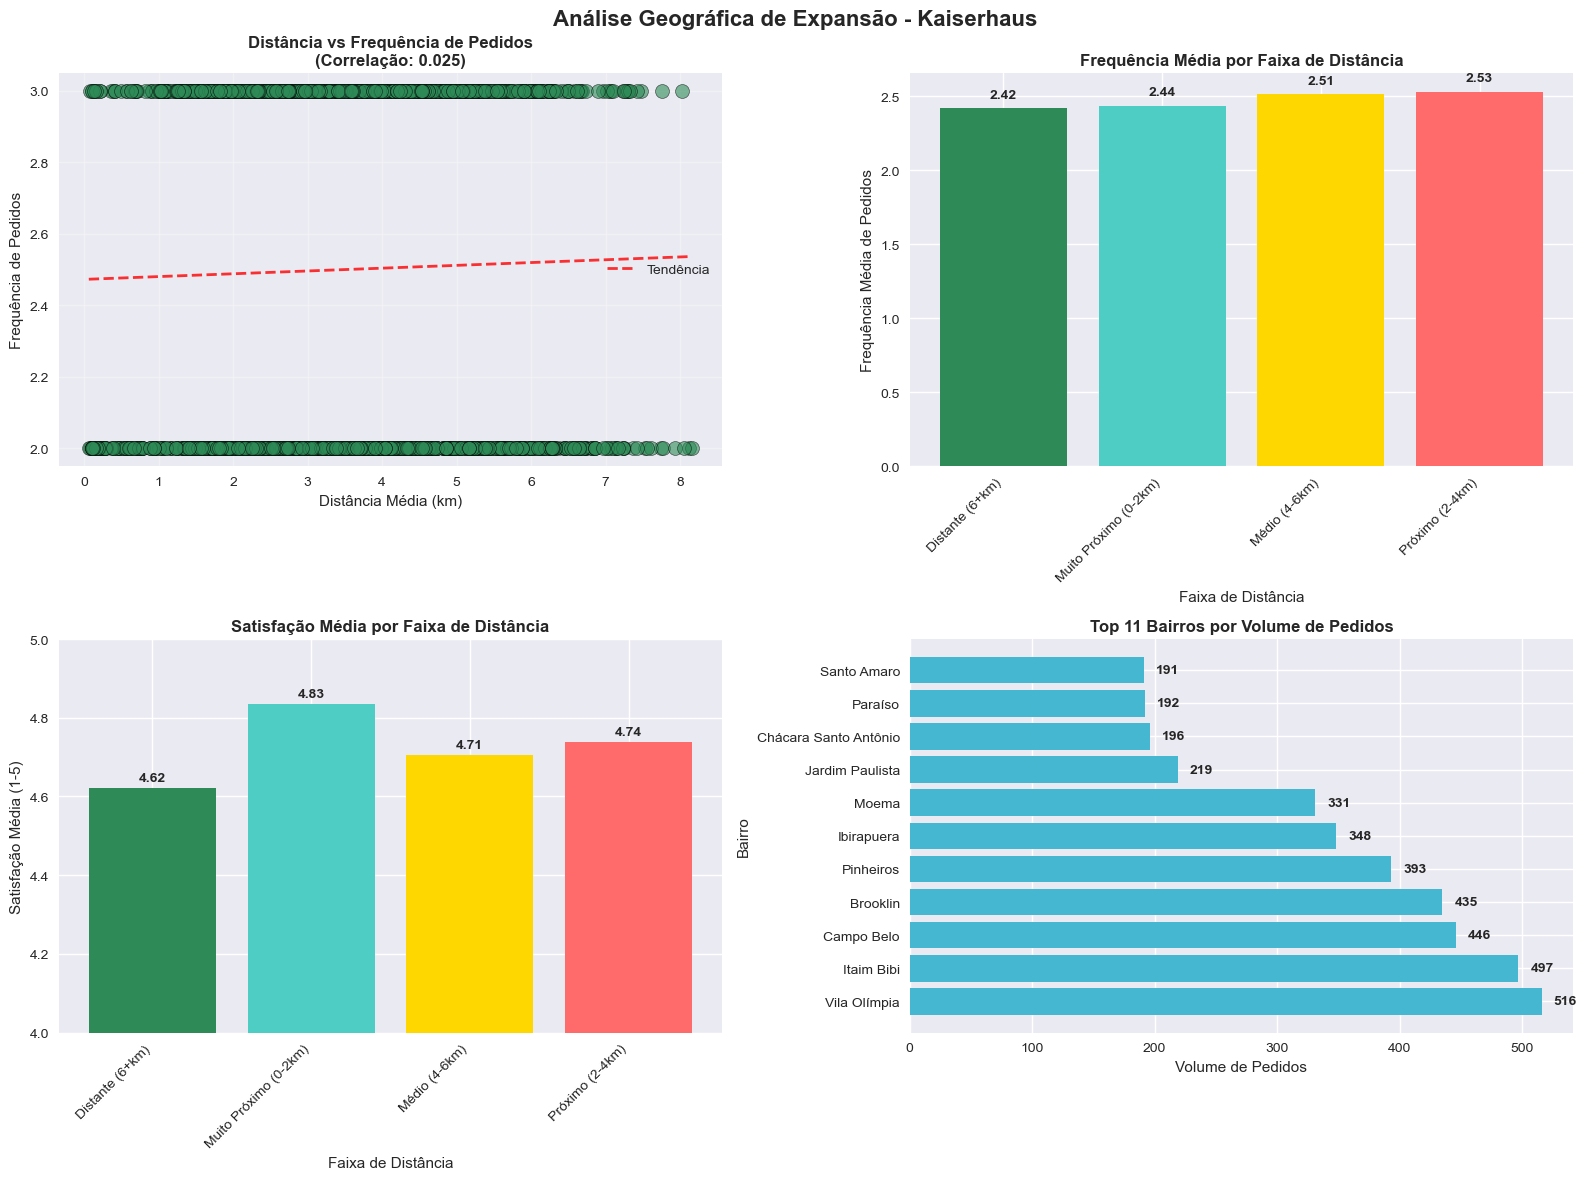

In [22]:
print("VISUALIZAÇÕES ESTRATÉGICAS")
print("=" * 50)


plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análise Geográfica de Expansão - Kaiserhaus', fontsize=16, fontweight='bold')

# gráfico 1: distância por frequência
ax1 = axes[0, 0]
scatter1 = ax1.scatter(frequencia_clientes['distancia_media_km'], 
                       frequencia_clientes['frequencia_pedidos'],
                       alpha=0.6, s=100, c='#2E8B57', edgecolors='black', linewidth=0.5)
ax1.set_title(f'Distância vs Frequência de Pedidos\n(Correlação: {correlacao_dist_freq:.3f})', 
              fontweight='bold')
ax1.set_xlabel('Distância Média (km)')
ax1.set_ylabel('Frequência de Pedidos')
ax1.grid(True, alpha=0.3)


z1 = np.polyfit(frequencia_clientes['distancia_media_km'], 
                frequencia_clientes['frequencia_pedidos'], 1)
p1 = np.poly1d(z1)
x_line = np.linspace(frequencia_clientes['distancia_media_km'].min(), 
                     frequencia_clientes['distancia_media_km'].max(), 100)
ax1.plot(x_line, p1(x_line), "r--", alpha=0.8, linewidth=2, label='Tendência')
ax1.legend()

# gráfico 2: frequência por faixa de distância
ax2 = axes[0, 1]
freq_por_faixa = frequencia_clientes.groupby('faixa_distancia')['frequencia_pedidos'].mean().sort_index()
colors_faixa = ['#2E8B57', '#4ECDC4', '#FFD700', '#FF6B6B']
bars2 = ax2.bar(range(len(freq_por_faixa)), freq_por_faixa.values, color=colors_faixa)
ax2.set_title('Frequência Média por Faixa de Distância', fontweight='bold')
ax2.set_ylabel('Frequência Média de Pedidos')
ax2.set_xlabel('Faixa de Distância')
ax2.set_xticks(range(len(freq_por_faixa)))
ax2.set_xticklabels(freq_por_faixa.index, rotation=45, ha='right')


for i, v in enumerate(freq_por_faixa.values):
    ax2.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# gráfico 3: satisfação por faixa de distância
ax3 = axes[1, 0]
sat_por_faixa = frequencia_clientes.groupby('faixa_distancia')['satisfacao_media'].mean().sort_index()
bars3 = ax3.bar(range(len(sat_por_faixa)), sat_por_faixa.values, color=colors_faixa)
ax3.set_title('Satisfação Média por Faixa de Distância', fontweight='bold')
ax3.set_ylabel('Satisfação Média (1-5)')
ax3.set_xlabel('Faixa de Distância')
ax3.set_xticks(range(len(sat_por_faixa)))
ax3.set_xticklabels(sat_por_faixa.index, rotation=45, ha='right')
ax3.set_ylim(4.0, 5.0)


for i, v in enumerate(sat_por_faixa.values):
    ax3.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# gráfico 4: distribuição de pedidos por bairro
ax4 = axes[1, 1]
top_bairros = analise_bairros.nlargest(11, 'pedidos')['pedidos']
bars4 = ax4.barh(range(len(top_bairros)), top_bairros.values, color='#45B7D1')
ax4.set_title('Top 11 Bairros por Volume de Pedidos', fontweight='bold')
ax4.set_xlabel('Volume de Pedidos')
ax4.set_ylabel('Bairro')
ax4.set_yticks(range(len(top_bairros)))
ax4.set_yticklabels(top_bairros.index)


for i, v in enumerate(top_bairros.values):
    ax4.text(v + 10, i, f'{int(v)}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()



TABELA: DISTRIBUIÇÃO DE DISTÂNCIAS
Intervalo (km)  Volume de Pedidos
   0.00 - 0.33               1048
   0.33 - 0.66                 96
   0.66 - 0.99                165
   0.99 - 1.33                104
   1.33 - 1.66                124
   1.66 - 1.99                 86
   1.99 - 2.32                132
   2.32 - 2.65                167
   2.65 - 2.98                162
   2.98 - 3.32                213
   3.32 - 3.65                193
   3.65 - 3.98                214
   3.98 - 4.31                233
   4.31 - 4.64                230
   4.64 - 4.97                238
   4.97 - 5.31                196
   5.31 - 5.64                231
   5.64 - 5.97                205
   5.97 - 6.30                191
   6.30 - 6.63                190
   6.63 - 6.96                136
   6.96 - 7.30                101
   7.30 - 7.63                110
   7.63 - 7.96                 61
   7.96 - 8.29                 57
   8.29 - 8.62                 50
   8.62 - 8.96                 32
   8.96 - 9.

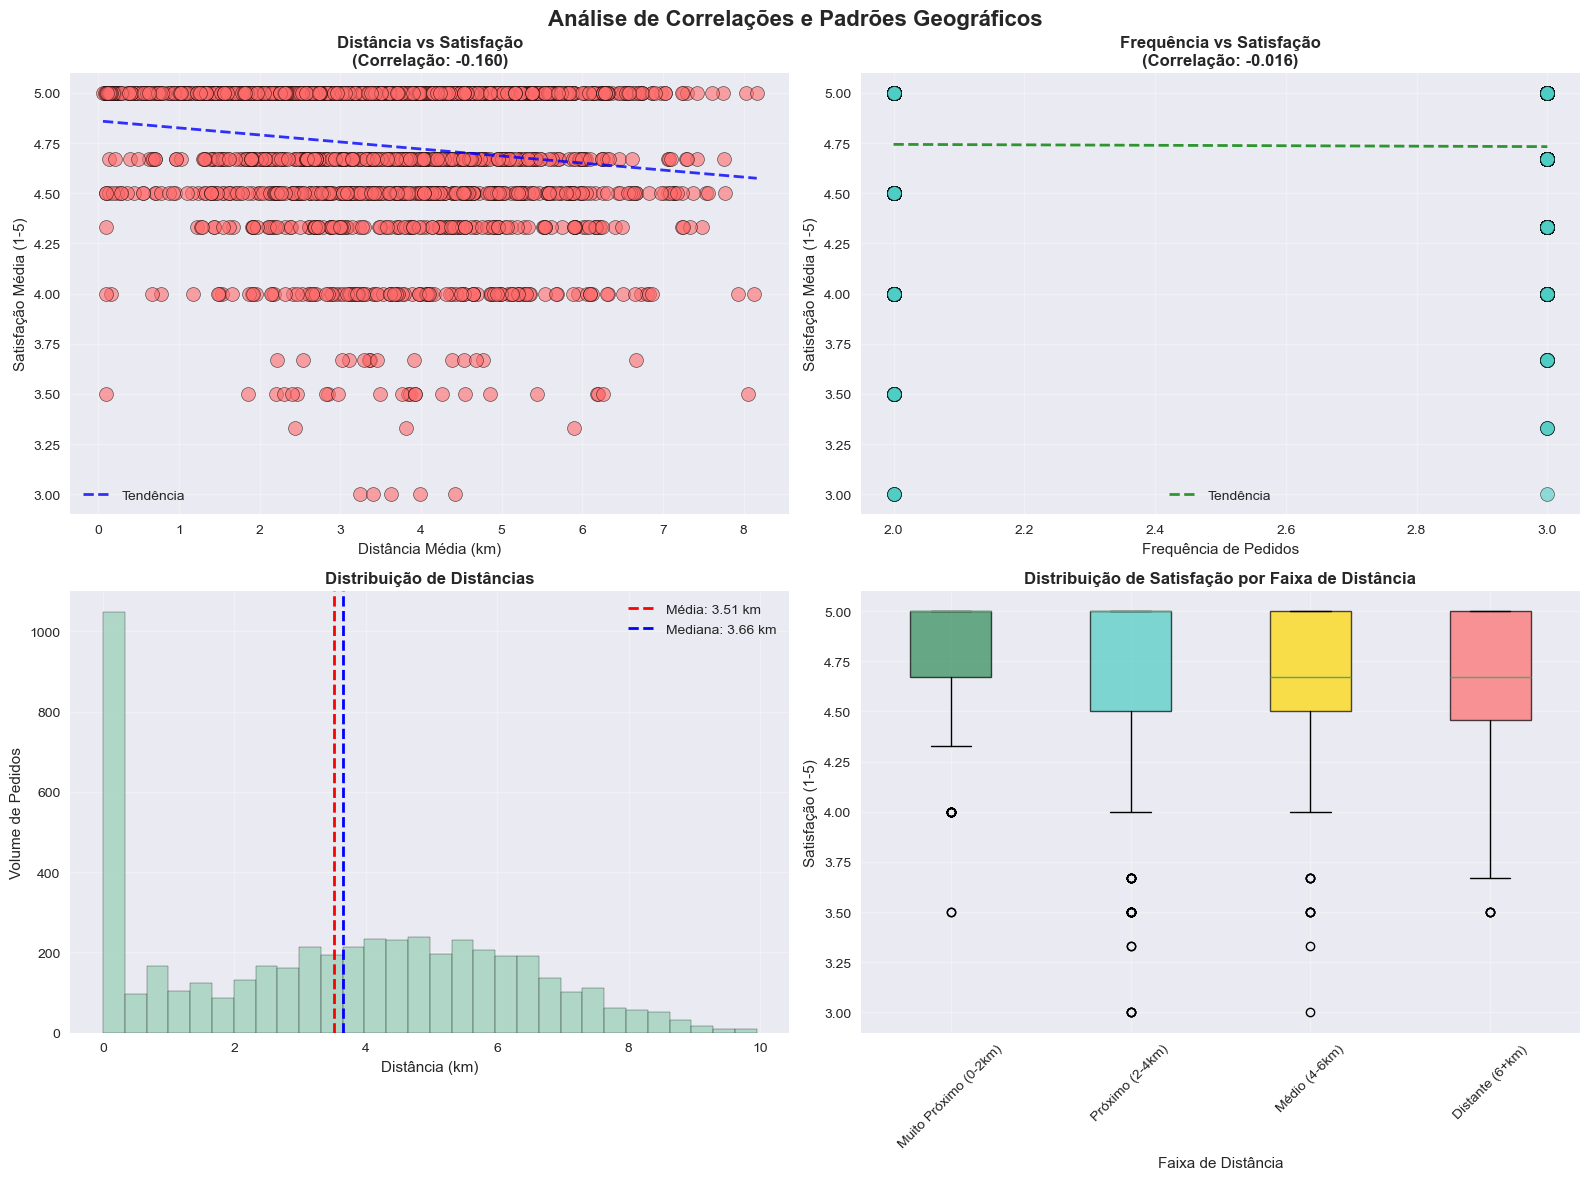

In [23]:
# gráficos (parte 2)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análise de Correlações e Padrões Geográficos', fontsize=16, fontweight='bold')

# gráfico 1: distância por satisfação
ax1 = axes[0, 0]
scatter2 = ax1.scatter(frequencia_clientes['distancia_media_km'], 
                       frequencia_clientes['satisfacao_media'],
                       alpha=0.6, s=100, c='#FF6B6B', edgecolors='black', linewidth=0.5)
ax1.set_title(f'Distância vs Satisfação\n(Correlação: {corr_dist_satisfacao:.3f})', 
              fontweight='bold')
ax1.set_xlabel('Distância Média (km)')
ax1.set_ylabel('Satisfação Média (1-5)')
ax1.grid(True, alpha=0.3)


z2 = np.polyfit(frequencia_clientes['distancia_media_km'], 
                frequencia_clientes['satisfacao_media'], 1)
p2 = np.poly1d(z2)
x_line2 = np.linspace(frequencia_clientes['distancia_media_km'].min(), 
                      frequencia_clientes['distancia_media_km'].max(), 100)
ax1.plot(x_line2, p2(x_line2), "b--", alpha=0.8, linewidth=2, label='Tendência')
ax1.legend()

# gráfico 2: frequência por satisfação
ax2 = axes[0, 1]
scatter3 = ax2.scatter(frequencia_clientes['frequencia_pedidos'], 
                       frequencia_clientes['satisfacao_media'],
                       alpha=0.6, s=100, c='#4ECDC4', edgecolors='black', linewidth=0.5)
ax2.set_title(f'Frequência vs Satisfação\n(Correlação: {corr_freq_satisfacao:.3f})', 
              fontweight='bold')
ax2.set_xlabel('Frequência de Pedidos')
ax2.set_ylabel('Satisfação Média (1-5)')
ax2.grid(True, alpha=0.3)


z3 = np.polyfit(frequencia_clientes['frequencia_pedidos'], 
                frequencia_clientes['satisfacao_media'], 1)
p3 = np.poly1d(z3)
x_line3 = np.linspace(frequencia_clientes['frequencia_pedidos'].min(), 
                      frequencia_clientes['frequencia_pedidos'].max(), 100)
ax2.plot(x_line3, p3(x_line3), "g--", alpha=0.8, linewidth=2, label='Tendência')
ax2.legend()


print("\nTABELA: DISTRIBUIÇÃO DE DISTÂNCIAS")
print("=" * 60)
hist_values, bin_edges = np.histogram(df['distance_km'], bins=30)
dist_table = pd.DataFrame({
    'Intervalo (km)': [f'{bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}' for i in range(len(bin_edges)-1)],
    'Volume de Pedidos': hist_values
})
print(dist_table.to_string(index=False))
print("=" * 60)

# gráfico 3: distribuição de distâncias
ax3 = axes[1, 0]
ax3.hist(df['distance_km'], bins=30, color='#96CEB4', alpha=0.7, edgecolor='black')
ax3.axvline(df['distance_km'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Média: {df["distance_km"].mean():.2f} km')
ax3.axvline(df['distance_km'].median(), color='blue', linestyle='--', linewidth=2,
            label=f'Mediana: {df["distance_km"].median():.2f} km')
ax3.set_title('Distribuição de Distâncias', fontweight='bold')
ax3.set_xlabel('Distância (km)')
ax3.set_ylabel('Volume de Pedidos')
ax3.legend()
ax3.grid(True, alpha=0.3)

# gráfico 4: satisfação por faixa de distância
ax4 = axes[1, 1]

faixas_ordenadas = ['Muito Próximo (0-2km)', 'Próximo (2-4km)', 'Médio (4-6km)', 'Distante (6+km)']
dados_boxplot = [frequencia_clientes[frequencia_clientes['faixa_distancia'] == faixa]['satisfacao_media'].values 
                 for faixa in faixas_ordenadas]
bp = ax4.boxplot(dados_boxplot, labels=faixas_ordenadas, patch_artist=True)


for patch, color in zip(bp['boxes'], colors_faixa):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax4.set_title('Distribuição de Satisfação por Faixa de Distância', fontweight='bold')
ax4.set_ylabel('Satisfação (1-5)')
ax4.set_xlabel('Faixa de Distância')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Insights e Recomendações para Expansão
**Objetivo:** Consolidar insights estratégicos para decisões de expansão geográfica.


In [24]:
print("INSIGHTS E RECOMENDAÇÕES ESTRATÉGICAS")
print("=" * 70)

print("\nPRINCIPAIS DESCOBERTAS:\n")

# 1: correlação distância-frequência
print("1. IMPACTO DA DISTÂNCIA NA FREQUÊNCIA DE PEDIDOS:")
print(f"   • Correlação: {correlacao_dist_freq:.4f}")
if abs(correlacao_dist_freq) > 0.3:
    direcao = "negativa" if correlacao_dist_freq < 0 else "positiva"
    print(f"   • Correlação {direcao} FORTE detectada!")
    if correlacao_dist_freq < 0:
        print(f"   • Clientes mais distantes tendem a fazer MENOS pedidos")
    else:
        print(f"   • Clientes mais distantes tendem a fazer MAIS pedidos")
else:
    print(f"   • Distância NÃO é barreira significativa para frequência")

# 2: correlação distância-satisfação
print(f"\n2. IMPACTO DA DISTÂNCIA NA SATISFAÇÃO:")
print(f"   • Correlação: {corr_dist_satisfacao:.4f}")
if abs(corr_dist_satisfacao) > 0.3:
    direcao = "negativa" if corr_dist_satisfacao < 0 else "positiva"
    print(f"   • Correlação {direcao} FORTE detectada!")
    if corr_dist_satisfacao < 0:
        print(f"   • Clientes distantes ficam MENOS satisfeitos")
        print(f"   • ATENÇÃO: Possível problema de logística/entrega")
    else:
        print(f"   • Clientes distantes ficam MAIS satisfeitos")
else:
    print(f"   • Qualidade do serviço mantida em todas as distâncias")

# 3: faixas de distância mais rentáveis
print(f"\n3. ANÁLISE DE FAIXAS DE DISTÂNCIA:")
faixa_melhor_freq = frequencia_clientes.groupby('faixa_distancia')['frequencia_pedidos'].mean().idxmax()
faixa_melhor_sat = frequencia_clientes.groupby('faixa_distancia')['satisfacao_media'].mean().idxmax()
print(f"   • Melhor frequência: {faixa_melhor_freq}")
print(f"   • Melhor satisfação: {faixa_melhor_sat}")

# 4: regiões
print(f"\n4. REGIÕES PRIORITÁRIAS PARA EXPANSÃO:")
top_3_regioes = analise_macro.nlargest(3, 'total_pedidos')
for i, (regiao, dados) in enumerate(top_3_regioes.iterrows(), 1):
    print(f"   {i}. {regiao}:")
    print(f"      • Pedidos: {dados['total_pedidos']}")
    print(f"      • Distância média: {dados['distancia_media']:.2f} km")
    print(f"      • Satisfação: {dados['satisfacao_media']:.2f}")

# Insight 5: Oportunidades de expansão
print(f"\n5. OPORTUNIDADES DE EXPANSÃO:")
# Regiões com alta satisfação mas baixo volume
regioes_potencial = analise_macro[
    (analise_macro['satisfacao_media'] > analise_macro['satisfacao_media'].median()) &
    (analise_macro['total_pedidos'] < analise_macro['total_pedidos'].median())
].sort_values('satisfacao_media', ascending=False)

if len(regioes_potencial) > 0:
    print(f"   • Regiões com alta satisfação mas baixo volume (potencial crescimento):")
    for regiao, dados in regioes_potencial.head(3).iterrows():
        print(f"      - {regiao}: Satisfação {dados['satisfacao_media']:.2f}, {dados['total_pedidos']} pedidos")
else:
    print(f"   • Todas as regiões de alta satisfação já têm alto volume")


print(f"\nRECOMENDAÇÕES ESTRATÉGICAS:\n")

if correlacao_dist_freq < -0.2:
    print("   1. Considerar abrir FILIAIS para reduzir distância média")
    print("      → Clientes distantes pedem menos frequentemente")
elif correlacao_dist_freq > 0.2:
    print("   1. Expandir alcance geográfico")
    print("      → Clientes distantes são igualmente ou mais engajados")
else:
    print("   1. Distância não é fator limitante significativo")

if corr_dist_satisfacao < -0.2:
    print("\n   2. PRIORIDADE: Melhorar logística de entrega para longas distâncias")
    print("      → Satisfação cai com a distância")
else:
    print("\n   2. Qualidade de serviço consistente em todas as distâncias")

print(f"\n   3. Focar em regiões de alta performance:")
for regiao in top_3_regioes.head(3).index:
    print(f"      • {regiao}")

print(f"\n   4. Explorar regiões sub-atendidas com alto potencial:")
if len(regioes_potencial) > 0:
    for regiao in regioes_potencial.head(3).index:
        print(f"      • {regiao}")
else:
    print(f"      • Todas as regiões principais já estão bem atendidas")

print("\n" + "=" * 70)


INSIGHTS E RECOMENDAÇÕES ESTRATÉGICAS

PRINCIPAIS DESCOBERTAS:

1. IMPACTO DA DISTÂNCIA NA FREQUÊNCIA DE PEDIDOS:
   • Correlação: 0.0254
   • Distância NÃO é barreira significativa para frequência

2. IMPACTO DA DISTÂNCIA NA SATISFAÇÃO:
   • Correlação: -0.1596
   • Qualidade do serviço mantida em todas as distâncias

3. ANÁLISE DE FAIXAS DE DISTÂNCIA:
   • Melhor frequência: Próximo (2-4km)
   • Melhor satisfação: Muito Próximo (0-2km)

4. REGIÕES PRIORITÁRIAS PARA EXPANSÃO:
   1. Brooklin:
      • Pedidos: 881.0
      • Distância média: 0.87 km
      • Satisfação: 4.83
   2. Moema:
      • Pedidos: 679.0
      • Distância média: 2.59 km
      • Satisfação: 4.79
   3. Vila Mariana:
      • Pedidos: 530.0
      • Distância média: 4.19 km
      • Satisfação: 4.74

5. OPORTUNIDADES DE EXPANSÃO:
   • Todas as regiões de alta satisfação já têm alto volume

RECOMENDAÇÕES ESTRATÉGICAS:

   1. Distância não é fator limitante significativo

   2. Qualidade de serviço consistente em todas as d

## 8. Análise Demográfica e Potencial de Mercado
**Objetivo:** Relacionar dados demográficos (população) com volume de pedidos e distância para identificar oportunidades de mercado.


In [25]:
# Dados demográficos dos bairros (fonte: IBGE)
# População em número de habitantes
dados_habitantes = {
    'bairro_destino': [
        'Bela Vista',
        'Liberdade',
        'Perdizes',
        'Morumbi',
        'Vila Mariana',
        'Jardins',
        'Santo Amaro',
        'Jardim Paulista',
        'Moema',
        'Pinheiros',
        'Brooklin',
        'Campo Belo',
        'Itaim Bibi',
        'Vila Olímpia'
    ],
    'habitantes': [
        60024,
        66056,
        111161,
        43690,
        127286,
        81859,
        85349,
        81859,
        81899,
        65145,
        17507,
        71034,
        80501,
        63129
    ]
}

df_habitantes = pd.DataFrame(dados_habitantes)


analise_bairros_completa = df.groupby('bairro_destino').agg({
    'order_datetime': 'count',
    'distance_km': 'mean',
    'satisfacao_nivel': 'mean',
    'total_brl': 'sum'
}).rename(columns={
    'order_datetime': 'volume_pedidos',
    'distance_km': 'distancia_media_km',
    'satisfacao_nivel': 'satisfacao_media',
    'total_brl': 'faturamento_total_brl'
}).round(2)


analise_demografica = analise_bairros_completa.merge(
    df_habitantes, 
    left_index=True, 
    right_on='bairro_destino', 
    how='inner'
)


analise_demografica['pedidos_per_capita'] = (
    analise_demografica['volume_pedidos'] / analise_demografica['habitantes'] * 1000
).round(2)  

analise_demografica['penetracao_mercado_%'] = (
    analise_demografica['volume_pedidos'] / analise_demografica['habitantes'] * 100
).round(2)

analise_demografica['faturamento_per_capita'] = (
    analise_demografica['faturamento_total_brl'] / analise_demografica['habitantes']
).round(2)

print("ANÁLISE DEMOGRÁFICA POR BAIRRO")
print("=" * 80)
print(f"\nBairros com dados demográficos: {len(analise_demografica)}")
print(f"População total analisada: {analise_demografica['habitantes'].sum():,.0f} habitantes")
print(f"\nDados por bairro:")
print(analise_demografica.sort_values('volume_pedidos', ascending=False).to_string())

print(f"\nMÉTRICAS DE PENETRAÇÃO DE MERCADO:")
print(f"• Média de pedidos por mil habitantes: {analise_demografica['pedidos_per_capita'].mean():.2f}")
print(f"• Bairro com maior penetração: {analise_demografica.loc[analise_demografica['pedidos_per_capita'].idxmax(), 'bairro_destino']} "
      f"({analise_demografica['pedidos_per_capita'].max():.2f} pedidos/mil hab)")
print(f"• Bairro com menor penetração: {analise_demografica.loc[analise_demografica['pedidos_per_capita'].idxmin(), 'bairro_destino']} "
      f"({analise_demografica['pedidos_per_capita'].min():.2f} pedidos/mil hab)")


ANÁLISE DEMOGRÁFICA POR BAIRRO

Bairros com dados demográficos: 14
População total analisada: 1,036,499 habitantes

Dados por bairro:
    volume_pedidos  distancia_media_km  satisfacao_media  faturamento_total_brl   bairro_destino  habitantes  pedidos_per_capita  penetracao_mercado_%  faturamento_per_capita
13             516                2.70              4.77               56087.36     Vila Olímpia       63129                8.17                  0.82                    0.89
12             497                3.28              4.72               55387.45       Itaim Bibi       80501                6.17                  0.62                    0.69
11             446                0.86              4.82               50884.81       Campo Belo       71034                6.28                  0.63                    0.72
10             435                0.88              4.85               46451.09         Brooklin       17507               24.85                  2.48                

In [27]:
# Análise de Correlações
print("\nANÁLISE DE CORRELAÇÕES")
print("=" * 80)

# Correlações
corr_habitantes_pedidos = analise_demografica['habitantes'].corr(analise_demografica['volume_pedidos'])
corr_habitantes_distancia = analise_demografica['habitantes'].corr(analise_demografica['distancia_media_km'])
corr_distancia_pedidos = analise_demografica['distancia_media_km'].corr(analise_demografica['volume_pedidos'])
corr_percapita_distancia = analise_demografica['pedidos_per_capita'].corr(analise_demografica['distancia_media_km'])

print(f"\n1. População vs Volume de Pedidos: {corr_habitantes_pedidos:.4f}")
if corr_habitantes_pedidos > 0.7:
    print("   → Correlação MUITO FORTE: Bairros maiores têm muito mais pedidos")
elif corr_habitantes_pedidos > 0.5:
    print("   → Correlação FORTE: População influencia positivamente o volume")
elif corr_habitantes_pedidos > 0.3:
    print("   → Correlação MODERADA: Há alguma relação entre população e pedidos")
else:
    print("   → Correlação FRACA: Volume não depende apenas do tamanho da população")

print(f"\n2. População vs Distância Média: {corr_habitantes_distancia:.4f}")
if abs(corr_habitantes_distancia) > 0.5:
    direcao = "mais distantes" if corr_habitantes_distancia > 0 else "mais próximos"
    print(f"   → Bairros maiores tendem a estar {direcao}")
else:
    print("   → População não tem relação clara com distância")

print(f"\n3. Distância vs Volume de Pedidos: {corr_distancia_pedidos:.4f}")
if corr_distancia_pedidos < -0.5:
    print("   → Correlação NEGATIVA FORTE: Distância reduz significativamente o volume")
elif corr_distancia_pedidos < -0.3:
    print("   → Correlação NEGATIVA MODERADA: Distância impacta o volume")
else:
    print("   → Distância não é barreira significativa para volume")

print(f"\n4. Pedidos per Capita vs Distância: {corr_percapita_distancia:.4f}")
if corr_percapita_distancia < -0.3:
    print("   → Penetração de mercado cai com a distância")
else:
    print("   → Penetração mantém-se estável independente da distância")

# Identificar oportunidades
print(f"\nOPORTUNIDADES DE CRESCIMENTO:")
print("=" * 80)

# Bairros com alta população mas baixa penetração (oportunidade)
analise_demografica['potencial'] = (
    analise_demografica['habitantes'] / analise_demografica['habitantes'].max() * 0.5 +
    (1 - analise_demografica['pedidos_per_capita'] / analise_demografica['pedidos_per_capita'].max()) * 0.5
)

top_oportunidades = analise_demografica.nlargest(5, 'potencial')[
    ['bairro_destino', 'habitantes', 'volume_pedidos', 'pedidos_per_capita', 'distancia_media_km']
]

print("\nTop 5 Bairros com Maior Potencial de Crescimento:")
print("(Alta população + Baixa penetração atual)")
print(top_oportunidades.to_string(index=False))

# Bairros com melhor performance
top_performance = analise_demografica.nlargest(5, 'pedidos_per_capita')[
    ['bairro_destino', 'habitantes', 'volume_pedidos', 'pedidos_per_capita', 'distancia_media_km']
]

print("\n\nTop 5 Bairros com Melhor Penetração de Mercado:")
print("(Maior número de pedidos por habitante)")
print(top_performance.to_string(index=False))



ANÁLISE DE CORRELAÇÕES

1. População vs Volume de Pedidos: -0.3343
   → Correlação FRACA: Volume não depende apenas do tamanho da população

2. População vs Distância Média: 0.2539
   → População não tem relação clara com distância

3. Distância vs Volume de Pedidos: -0.8012
   → Correlação NEGATIVA FORTE: Distância reduz significativamente o volume

4. Pedidos per Capita vs Distância: -0.6860
   → Penetração de mercado cai com a distância

OPORTUNIDADES DE CRESCIMENTO:

Top 5 Bairros com Maior Potencial de Crescimento:
(Alta população + Baixa penetração atual)
 bairro_destino  habitantes  volume_pedidos  pedidos_per_capita  distancia_media_km
   Vila Mariana      127286             172                1.35                4.06
       Perdizes      111161              98                0.88                6.00
    Santo Amaro       85349             191                2.24                4.85
        Jardins       81859             184                2.25                4.59
Jardim Paul


GERANDO VISUALIZAÇÕES...


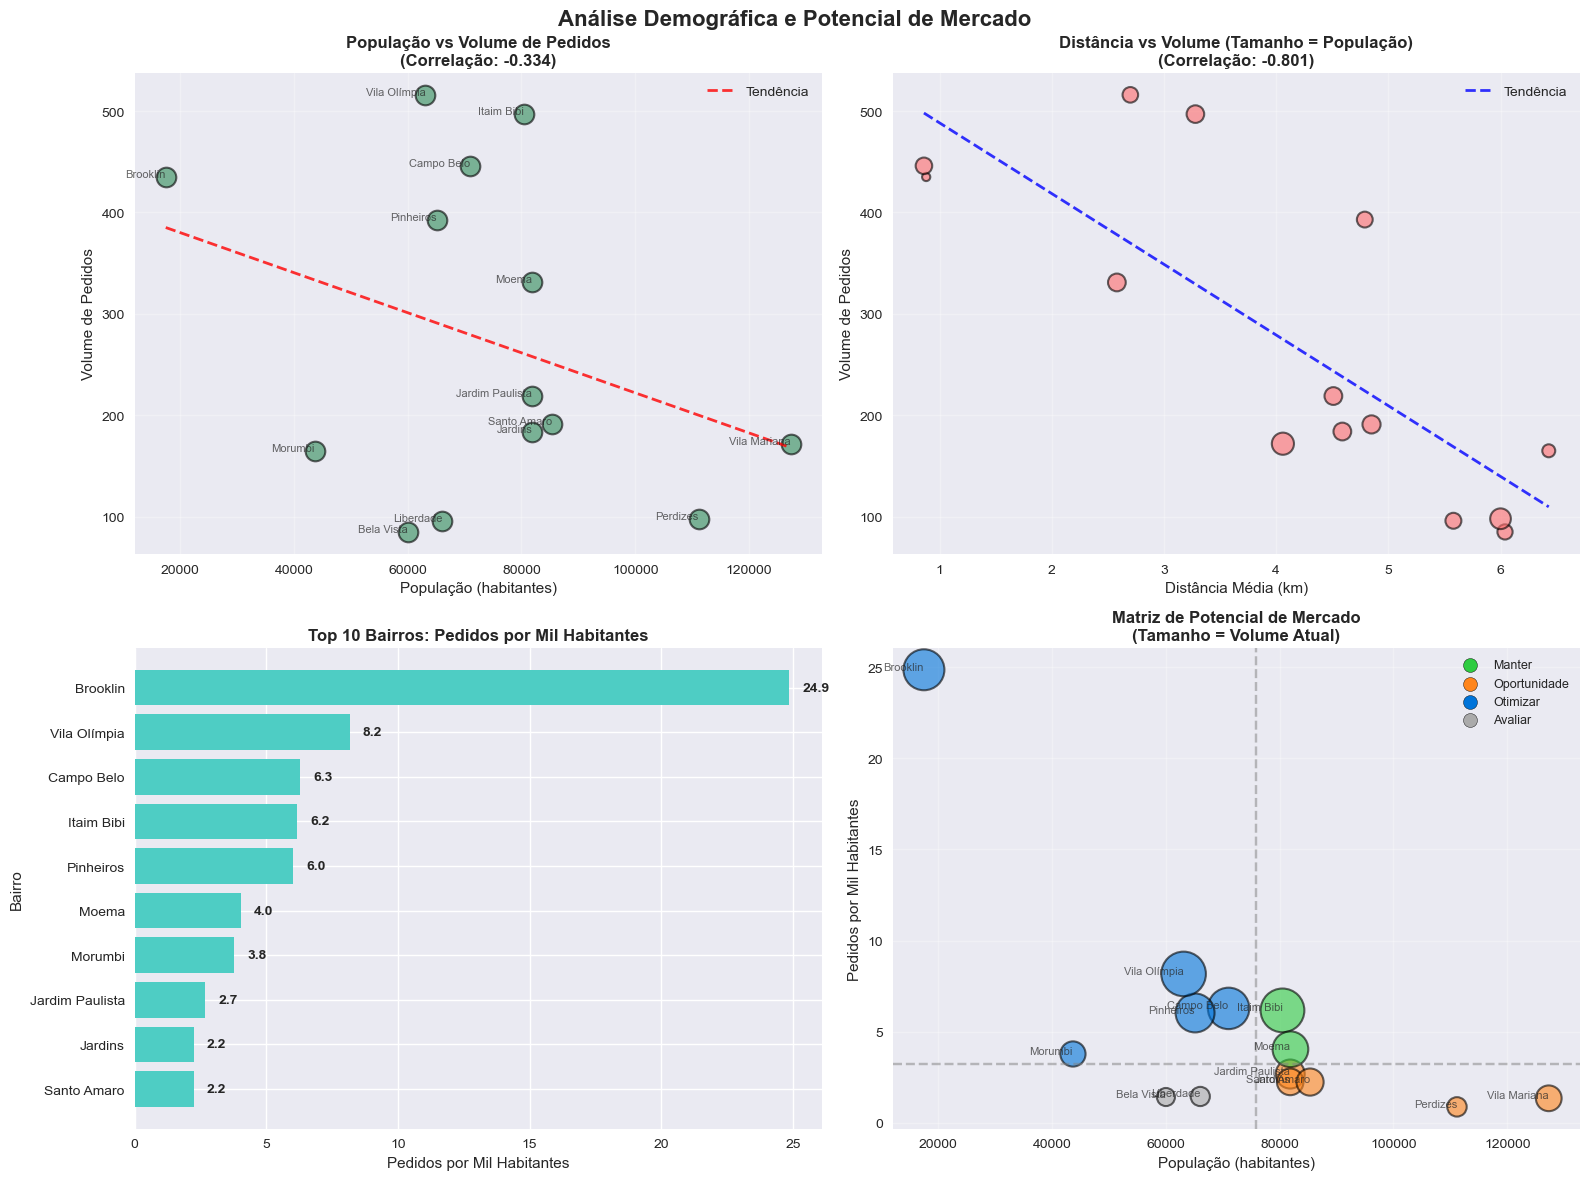


Visualizações geradas com sucesso!


In [28]:

print("\nGERANDO VISUALIZAÇÕES...")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análise Demográfica e Potencial de Mercado', fontsize=16, fontweight='bold')

# gráfico 1: População vs Volume de Pedidos
ax1 = axes[0, 0]
scatter1 = ax1.scatter(analise_demografica['habitantes'], 
                       analise_demografica['volume_pedidos'],
                       s=200, alpha=0.6, c='#2E8B57', edgecolors='black', linewidth=1.5)
ax1.set_title(f'População vs Volume de Pedidos\n(Correlação: {corr_habitantes_pedidos:.3f})', 
              fontweight='bold')
ax1.set_xlabel('População (habitantes)')
ax1.set_ylabel('Volume de Pedidos')
ax1.grid(True, alpha=0.3)


z1 = np.polyfit(analise_demografica['habitantes'], analise_demografica['volume_pedidos'], 1)
p1 = np.poly1d(z1)
x_line1 = np.linspace(analise_demografica['habitantes'].min(), 
                      analise_demografica['habitantes'].max(), 100)
ax1.plot(x_line1, p1(x_line1), "r--", alpha=0.8, linewidth=2, label='Tendência')


for idx, row in analise_demografica.iterrows():
    ax1.annotate(row['bairro_destino'], 
                (row['habitantes'], row['volume_pedidos']),
                fontsize=8, alpha=0.7, ha='right')
ax1.legend()

# Gráfico 2: Distância vs Volume (tamanho = população)
ax2 = axes[0, 1]
scatter2 = ax2.scatter(analise_demografica['distancia_media_km'], 
                       analise_demografica['volume_pedidos'],
                       s=analise_demografica['habitantes']/500,  # Tamanho proporcional à população
                       alpha=0.6, c='#FF6B6B', edgecolors='black', linewidth=1.5)
ax2.set_title(f'Distância vs Volume (Tamanho = População)\n(Correlação: {corr_distancia_pedidos:.3f})', 
              fontweight='bold')
ax2.set_xlabel('Distância Média (km)')
ax2.set_ylabel('Volume de Pedidos')
ax2.grid(True, alpha=0.3)


z2 = np.polyfit(analise_demografica['distancia_media_km'], analise_demografica['volume_pedidos'], 1)
p2 = np.poly1d(z2)
x_line2 = np.linspace(analise_demografica['distancia_media_km'].min(), 
                      analise_demografica['distancia_media_km'].max(), 100)
ax2.plot(x_line2, p2(x_line2), "b--", alpha=0.8, linewidth=2, label='Tendência')
ax2.legend()

# Gráfico 3: Penetração de Mercado (Pedidos per Capita)
ax3 = axes[1, 0]
top_percapita = analise_demografica.nlargest(10, 'pedidos_per_capita').sort_values('pedidos_per_capita')
bars3 = ax3.barh(range(len(top_percapita)), top_percapita['pedidos_per_capita'].values, color='#4ECDC4')
ax3.set_title('Top 10 Bairros: Pedidos por Mil Habitantes', fontweight='bold')
ax3.set_xlabel('Pedidos por Mil Habitantes')
ax3.set_ylabel('Bairro')
ax3.set_yticks(range(len(top_percapita)))
ax3.set_yticklabels(top_percapita['bairro_destino'].values)


for i, v in enumerate(top_percapita['pedidos_per_capita'].values):
    ax3.text(v + 0.5, i, f'{v:.1f}', ha='left', va='center', fontweight='bold')

# Gráfico 4: Matriz de Potencial (População x Penetração)
ax4 = axes[1, 1]


media_habitantes = analise_demografica['habitantes'].median()
media_percapita = analise_demografica['pedidos_per_capita'].median()

colors = []
for _, row in analise_demografica.iterrows():
    if row['habitantes'] > media_habitantes and row['pedidos_per_capita'] > media_percapita:
        colors.append('#2ECC40')  
    elif row['habitantes'] > media_habitantes and row['pedidos_per_capita'] <= media_percapita:
        colors.append('#FF851B')  
    elif row['habitantes'] <= media_habitantes and row['pedidos_per_capita'] > media_percapita:
        colors.append('#0074D9')  
    else:
        colors.append('#AAAAAA')  

scatter4 = ax4.scatter(analise_demografica['habitantes'], 
                       analise_demografica['pedidos_per_capita'],
                       s=analise_demografica['volume_pedidos']*2,
                       alpha=0.6, c=colors, edgecolors='black', linewidth=1.5)

ax4.axvline(media_habitantes, color='gray', linestyle='--', alpha=0.5)
ax4.axhline(media_percapita, color='gray', linestyle='--', alpha=0.5)

ax4.set_title('Matriz de Potencial de Mercado\n(Tamanho = Volume Atual)', fontweight='bold')
ax4.set_xlabel('População (habitantes)')
ax4.set_ylabel('Pedidos por Mil Habitantes')
ax4.grid(True, alpha=0.3)


for idx, row in analise_demografica.iterrows():
    ax4.annotate(row['bairro_destino'], 
                (row['habitantes'], row['pedidos_per_capita']),
                fontsize=8, alpha=0.7, ha='right')


legend_elements = [
    plt.scatter([], [], s=100, c='#2ECC40', edgecolors='black', label='Manter'),
    plt.scatter([], [], s=100, c='#FF851B', edgecolors='black', label='Oportunidade'),
    plt.scatter([], [], s=100, c='#0074D9', edgecolors='black', label='Otimizar'),
    plt.scatter([], [], s=100, c='#AAAAAA', edgecolors='black', label='Avaliar')
]
ax4.legend(handles=legend_elements, loc='best', fontsize=9)

plt.tight_layout()
plt.show()

print("\nVisualizações geradas com sucesso!")


In [29]:

print("\nINSIGHTS E RECOMENDAÇÕES - ANÁLISE DEMOGRÁFICA")
print("=" * 80)

print("\nPRINCIPAIS DESCOBERTAS:\n")

# 1. Relação População-Volume
print("1. RELAÇÃO POPULAÇÃO vs VOLUME:")
if corr_habitantes_pedidos > 0.5:
    print(f"   • Correlação forte ({corr_habitantes_pedidos:.3f}): Bairros maiores geram mais pedidos")
    print(f"   • Estratégia: Priorizar bairros populosos para expansão")
else:
    print(f"   • Correlação moderada ({corr_habitantes_pedidos:.3f}): Volume não depende só da população")
    print(f"   • Outros fatores (renda, cultura) também são importantes")

# 2. Penetração de mercado
media_penetracao = analise_demografica['pedidos_per_capita'].mean()
max_penetracao = analise_demografica['pedidos_per_capita'].max()
min_penetracao = analise_demografica['pedidos_per_capita'].min()

print(f"\n2. PENETRAÇÃO DE MERCADO:")
print(f"   • Média: {media_penetracao:.2f} pedidos/mil habitantes")
print(f"   • Variação: {min_penetracao:.2f} - {max_penetracao:.2f} pedidos/mil hab")
print(f"   • Diferença: {(max_penetracao/min_penetracao - 1)*100:.0f}% entre melhor e pior")

# 3. Impacto da distância
print(f"\n3. IMPACTO DA DISTÂNCIA NA CAPTAÇÃO:")
if corr_distancia_pedidos < -0.5:
    print(f"   CRÍTICO: Distância reduz fortemente o volume ({corr_distancia_pedidos:.3f})")
    print(f"   • Recomendação: Abrir filiais ou melhorar logística")
elif corr_distancia_pedidos < -0.3:
    print(f"   Distância impacta moderadamente ({corr_distancia_pedidos:.3f})")
    print(f"   • Recomendação: Marketing direcionado para bairros distantes")
else:
    print(f"   Distância não é barreira significativa ({corr_distancia_pedidos:.3f})")
    print(f"   • Operação consegue atender bem todas as regiões")

# 4. Quadrantes estratégicos
print(f"\n4. SEGMENTAÇÃO ESTRATÉGICA DOS BAIRROS:\n")


media_hab = analise_demografica['habitantes'].median()
media_perc = analise_demografica['pedidos_per_capita'].median()

manter = analise_demografica[
    (analise_demografica['habitantes'] > media_hab) & 
    (analise_demografica['pedidos_per_capita'] > media_perc)
]
oportunidade = analise_demografica[
    (analise_demografica['habitantes'] > media_hab) & 
    (analise_demografica['pedidos_per_capita'] <= media_perc)
]
otimizar = analise_demografica[
    (analise_demografica['habitantes'] <= media_hab) & 
    (analise_demografica['pedidos_per_capita'] > media_perc)
]
avaliar = analise_demografica[
    (analise_demografica['habitantes'] <= media_hab) & 
    (analise_demografica['pedidos_per_capita'] <= media_perc)
]

print(f"   MANTER ({len(manter)} bairros): Alta população + Alta penetração")
if len(manter) > 0:
    print(f"      Bairros: {', '.join(manter['bairro_destino'].values)}")
    print(f"      → Continuar investindo para manter liderança\n")

print(f"   OPORTUNIDADE ({len(oportunidade)} bairros): Alta população + Baixa penetração")
if len(oportunidade) > 0:
    print(f"      Bairros: {', '.join(oportunidade['bairro_destino'].values)}")
    print(f"      → PRIORIDADE MÁXIMA: Grande mercado sub-explorado!\n")

print(f"   OTIMIZAR ({len(otimizar)} bairros): Baixa população + Alta penetração")
if len(otimizar) > 0:
    print(f"      Bairros: {', '.join(otimizar['bairro_destino'].values)}")
    print(f"      → Otimizar operação e manter qualidade\n")

print(f"   AVALIAR ({len(avaliar)} bairros): Baixa população + Baixa penetração")
if len(avaliar) > 0:
    print(f"      Bairros: {', '.join(avaliar['bairro_destino'].values)}")
    print(f"      → Avaliar viabilidade ou reduzir investimentos\n")

# Recomendações finais
print("\nPLANO DE AÇÃO RECOMENDADO:\n")

if len(oportunidade) > 0:
    print("1. CURTO PRAZO - Capturar Oportunidades:")
    for idx, (_, bairro) in enumerate(oportunidade.nlargest(3, 'habitantes').iterrows(), 1):
        print(f"   {idx}. {bairro['bairro_destino']}: {bairro['habitantes']:,.0f} hab, "
              f"apenas {bairro['pedidos_per_capita']:.1f} pedidos/mil hab")
    print(f"   → Ações: Marketing agressivo, promoções, parcerias locais\n")

if len(manter) > 0:
    print("2. MÉDIO PRAZO - Defender Posição:")
    for idx, (_, bairro) in enumerate(manter.nlargest(3, 'volume_pedidos').iterrows(), 1):
        print(f"   {idx}. {bairro['bairro_destino']}: {bairro['volume_pedidos']} pedidos, "
              f"{bairro['pedidos_per_capita']:.1f} pedidos/mil hab")
    print(f"   → Ações: Programas de fidelidade, manter qualidade\n")

if len(avaliar) > 0:
    print("3. LONGO PRAZO - Avaliar Viabilidade:")
    for idx, (_, bairro) in enumerate(avaliar.iterrows(), 1):
        if idx <= 3:
            print(f"   {idx}. {bairro['bairro_destino']}: {bairro['habitantes']:,.0f} hab, "
                  f"{bairro['volume_pedidos']} pedidos")
    print(f"   → Ações: Análise custo-benefício, possível redução de área de cobertura")

print("\n" + "=" * 80)



INSIGHTS E RECOMENDAÇÕES - ANÁLISE DEMOGRÁFICA

PRINCIPAIS DESCOBERTAS:

1. RELAÇÃO POPULAÇÃO vs VOLUME:
   • Correlação moderada (-0.334): Volume não depende só da população
   • Outros fatores (renda, cultura) também são importantes

2. PENETRAÇÃO DE MERCADO:
   • Média: 5.11 pedidos/mil habitantes
   • Variação: 0.88 - 24.85 pedidos/mil hab
   • Diferença: 2724% entre melhor e pior

3. IMPACTO DA DISTÂNCIA NA CAPTAÇÃO:
   CRÍTICO: Distância reduz fortemente o volume (-0.801)
   • Recomendação: Abrir filiais ou melhorar logística

4. SEGMENTAÇÃO ESTRATÉGICA DOS BAIRROS:

   MANTER (2 bairros): Alta população + Alta penetração
      Bairros: Itaim Bibi, Moema
      → Continuar investindo para manter liderança

   OPORTUNIDADE (5 bairros): Alta população + Baixa penetração
      Bairros: Jardim Paulista, Jardins, Perdizes, Santo Amaro, Vila Mariana
      → PRIORIDADE MÁXIMA: Grande mercado sub-explorado!

   OTIMIZAR (5 bairros): Baixa população + Alta penetração
      Bairros: Brookl